<a href="https://colab.research.google.com/github/lucarenz1997/lucarenz1997.github.io/blob/main/CDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# connect your google drive to this notebook

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Required Packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [48]:
# create same structure in your google drive as you see here

# load the csv into a dataframe
transactions = pd.read_csv('/content/drive/MyDrive/Master/CDA/card_transactions_2023.csv')

In [ ]:
# get a quick insight into the first few data rows

transactions.head()

customer_id country  type              trx_date  \
0  88a27d10-ea7e-4989-af14-df1f9f1d9db4      ch   pos  2022-12-31T23:59:58Z   
1  699e0b57-06b4-4f22-a571-7209327d7d20      us   pos  2023-01-01T00:00:44Z   
2  02928ca6-342d-4de9-aa6e-3a6afe40aacf      us   pos  2023-01-01T00:01:00Z   
3  6723e6c2-372c-48e3-87e3-21839baa95f3      ch   pos  2023-01-01T00:02:26Z   
4  08112684-e51b-4b14-9853-f05b4ddb4520      fr  ecom  2023-01-01T00:03:22Z   

   amount_chf orig_currency     category     mcc               counterpart  
0       15.00           chf  restaurants  5813.0                   SumUp    
1      342.74           usd     shopping  5999.0          MR FIREWORKS 508  
2       19.31           usd     shopping  5310.0             TARGET T-0201  
3        4.80           chf  restaurants  5813.0  WEISSE ARENA HOSPITALITY  
4        5.89           eur    transport  4789.0                       LIM

In [16]:
# what column has what data type (useful to know if you have a numerical category)

transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475414 entries, 0 to 475414
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   customer_id    475414 non-null  object  
 1   country        475414 non-null  object  
 2   type           475414 non-null  object  
 3   trx_date       475414 non-null  object  
 4   amount_chf     475414 non-null  float64 
 5   orig_currency  475414 non-null  object  
 6   category       475414 non-null  object  
 7   mcc            475412 non-null  category
 8   counterpart    475364 non-null  object  
dtypes: category(1), float64(1), object(7)
memory usage: 33.6+ MB


#***Preprocessing steps***

In [49]:
# example: mcc doesn't make sense as a number (the mean of MCC doesn't give us any information). Hence, we treat it as a category (no mean, standard deviation, etc. calculations to be done)

transactions['mcc'] = transactions['mcc'].astype('category')

In [31]:
transactions.describe()

amount_chf
count  475415.000000
mean       44.193468
std       147.084005
min         0.010000
25%         5.950000
50%        14.080000
75%        36.000000
max     14075.450000

In [50]:
# show all values that exist in column 'category'

transactions['category'].unique()

array(['restaurants', 'shopping', 'transport', 'cash', 'communication',
       'general', 'groceries', 'entertainment', 'holidays', 'tax',
       'health', 'education', 'living', 'savings', 'wellness',
       'Groceries', 'GVS Markt', 'Shopping', 'Restaurant', 'Hotel',
       'salary', 'Health', 'Holidays', 're'], dtype=object)

In [51]:
# map RESTAURANTS to RESTAURANT

mappings = {'RESTAURANTS': 'RESTAURANT'}

In [52]:
# set all categories to UPPERCASE

transactions['category'] = transactions['category'].str.upper().replace(mappings)

In [53]:
# recheck values (only 1 restaurant category now)

transactions['category'].unique()

array(['RESTAURANT', 'SHOPPING', 'TRANSPORT', 'CASH', 'COMMUNICATION',
       'GENERAL', 'GROCERIES', 'ENTERTAINMENT', 'HOLIDAYS', 'TAX',
       'HEALTH', 'EDUCATION', 'LIVING', 'SAVINGS', 'WELLNESS',
       'GVS MARKT', 'HOTEL', 'SALARY', 'RE'], dtype=object)

In [54]:
# only one transaction with type = nan. let's delete that
transactions[(transactions['type'] != 'pos') & (transactions['type'] != 'ecom')]
transactions = transactions.dropna(subset='type')

In [55]:
# how many transactions have "NaN" (not a number) in their rows (per column)

transactions.isna().sum()

customer_id       0
country           0
type              0
trx_date          0
amount_chf        0
orig_currency     0
category          0
mcc               2
counterpart      50
dtype: int64

In [56]:
# transactions without MCC. # Also , you see that trx_date is not of type date. Fix this with next step
transactions[transactions['mcc'].isna()]

customer_id country  type  \
273764  bb15d2fd-6573-4a58-aff0-56c11c57ae44     che  ecom   
475414  8f07ac00-eab8-4507-a3e4-e46aec86e893      ch   pos   

                              trx_date  amount_chf orig_currency category mcc  \
273764  2023-06-13T09:28:35.068405033Z      108.35           chf  GENERAL NaN   
475414            2023-10-02T09:46:36Z       12.25           chf       RE NaN   

       counterpart  
273764   Yapeal AG  
475414         NaN

In [58]:
#Remove from NaN MCC from dataset
transactions = transactions.dropna(subset=['mcc'])


In [80]:
# Convert 'mcc' column to integer
transactions['mcc'] = transactions['mcc'].astype(str).str.split('.').str[0].astype(int)

# Convert 'mcc' column back to category type
transactions['mcc'] = transactions['mcc'].astype('category')

In [75]:
# set trx_date as dateteime datatype and make sure we have a structure

transactions['trx_date'] = pd.to_datetime(transactions['trx_date']).dt.strftime('%Y-%m-%dT%H:%M:%SZ')

In [63]:
# standardize it (not sure if necessary)
def trim_to_seconds(dt):
    return dt.replace(microsecond=0)

transactions['trx_date'] = transactions['trx_date'].apply(trim_to_seconds)

In [71]:
# double check that no entries are there anymore

transactions[transactions['mcc'].isna()]

Empty DataFrame
Columns: [customer_id, country, type, trx_date, amount_chf, orig_currency, category, mcc, counterpart]
Index: []

49 Counterparts are NaN. Let's set them as "unknown"

In [66]:
transactions.fillna(value='UNKNOWN', inplace=True)

## Free of any NaNs

In [68]:
transactions.isna().sum()

customer_id      0
country          0
type             0
trx_date         0
amount_chf       0
orig_currency    0
category         0
mcc              0
counterpart      0
dtype: int64

In [81]:
transactions

customer_id country  type  \
0       88a27d10-ea7e-4989-af14-df1f9f1d9db4      ch   pos   
1       699e0b57-06b4-4f22-a571-7209327d7d20      us   pos   
2       02928ca6-342d-4de9-aa6e-3a6afe40aacf      us   pos   
3       6723e6c2-372c-48e3-87e3-21839baa95f3      ch   pos   
4       08112684-e51b-4b14-9853-f05b4ddb4520      fr  ecom   
...                                      ...     ...   ...   
475409  54d89a89-0f0c-4dbc-b7ea-bf6e3642ec6b      fr   pos   
475410  feb77f1d-a659-410f-96de-09d771558e3e      ch   pos   
475411  12b05d50-ef52-4aec-bf01-36d1df8327fa      ch   pos   
475412  5ff8f761-9cae-4e36-bea0-843646408022      om   pos   
475413  7ceb2017-f85b-480c-87ef-a1ed047d1013      ch  ecom   

                    trx_date  amount_chf orig_currency       category   mcc  \
0       2022-12-31T23:59:58Z       15.00           chf     RESTAURANT  5813   
1       2023-01-01T00:00:44Z      342.74           usd       SHOPPING  5999   
2       2023-01-01T00:01:00Z       19.31           usd       SHOPPING  5310   
3       2023-01-01T00:02:26Z        4.80           chf     RESTAURANT  5813   
4       2023-01-01T00:03:22Z        5.89           eur      TRANSPORT  4789   
...                      ...         ...           ...            ...   ...   
475409  2023-10-02T09:42:48Z       15.61           eur         HEALTH  5912   
475410  2023-10-02T09:43:29Z       36.00           chf      GROCERIES  5411   
475411  2023-10-02T09:43:37Z        1.50           chf      GROCERIES  5411   
475412  2023-10-02T09:44:01Z       19.05           omr      TRANSPORT  5541   
475413  2023-10-02T09:45:37Z       50.00           chf  ENTERTAINMENT  7995   

                      counterpart  
0                         SumUp    
1                MR FIREWORKS 508  
2                   TARGET T-0201  
3        WEISSE ARENA HOSPITALITY  
4                             LIM  
...                           ...  
475409            PHARMACIE DES A  
475410              Lidl Pratteln  
475411  MIG MIGROLINO WTHUR-MARKT  
475412  SHELL OMAN - AL WADI AL K  
475413                        CDL  

[475412 rows x 9 columns]

In [83]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475412 entries, 0 to 475413
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   customer_id    475412 non-null  object  
 1   country        475412 non-null  object  
 2   type           475412 non-null  object  
 3   trx_date       475412 non-null  object  
 4   amount_chf     475412 non-null  float64 
 5   orig_currency  475412 non-null  object  
 6   category       475412 non-null  object  
 7   mcc            475412 non-null  category
 8   counterpart    475412 non-null  object  
dtypes: category(1), float64(1), object(7)
memory usage: 33.6+ MB


# ***Analysis***

# Individually spent money in total per customer_id

In [131]:
sum_of_categories_per_customer = transactions.groupby(['customer_id', 'category'])['amount_chf'].sum()

# Convert series back to dataframe
sum_of_categories_per_customer = sum_of_categories_per_customer.reset_index()

print(sum_of_categories_per_customer.head())


# Add a column 'total' with the total amount spent for each customer_id
sum_of_categories_per_customer['total_expenditure'] = sum_of_categories_per_customer.groupby('customer_id')['amount_chf'].transform('sum')
print(sum_of_categories_per_customer)



                            customer_id       category  amount_chf
0  00007c83-96c3-4a3c-bbe0-dbca23348700  COMMUNICATION       18.24
1  00007c83-96c3-4a3c-bbe0-dbca23348700         HEALTH       93.90
2  00007c83-96c3-4a3c-bbe0-dbca23348700       HOLIDAYS        3.47
3  00007c83-96c3-4a3c-bbe0-dbca23348700     RESTAURANT        7.40
4  00007c83-96c3-4a3c-bbe0-dbca23348700       SHOPPING       46.05
                                customer_id       category  amount_chf  \
0      00007c83-96c3-4a3c-bbe0-dbca23348700  COMMUNICATION       18.24   
1      00007c83-96c3-4a3c-bbe0-dbca23348700         HEALTH       93.90   
2      00007c83-96c3-4a3c-bbe0-dbca23348700       HOLIDAYS        3.47   
3      00007c83-96c3-4a3c-bbe0-dbca23348700     RESTAURANT        7.40   
4      00007c83-96c3-4a3c-bbe0-dbca23348700       SHOPPING       46.05   
...                                     ...            ...         ...   
22483  ffba41c1-f39d-4655-b876-5497f85de500       HOLIDAYS      314.96   
22484 

# **Customers with most money spent in descending order**

In [132]:
# Reset index to make customer_id a regular column
sum_of_categories_per_customer = sum_of_categories_per_customer.reset_index()

# Create a new DataFrame with customer_id and total_expenditure
most_profitable_customers = sum_of_categories_per_customer[['customer_id', 'total_expenditure']].drop_duplicates(subset='customer_id')

# Sort the DataFrame by total_expenditure in descending order
most_profitable_customers = most_profitable_customers.sort_values(by='total_expenditure', ascending=False)
top_10 = most_profitable_customers.head(10)
# Print the top 10 most profitable customers
print(most_profitable_customers.head(10))

                                customer_id  total_expenditure
3000   22a205da-7984-4591-8047-3adca66de166          129348.78
21028  f15ebecd-7ac0-4ae4-95f3-8ebdabc17ffe          122317.63
8914   699e0b57-06b4-4f22-a571-7209327d7d20          110547.29
17018  c55c9942-f94e-4365-a0ab-e6a74b00bf78           89467.71
17362  c8924a3e-b7e7-412e-b58b-8f556675b87c           87516.50
14594  a8f92828-d634-42a6-82a5-854013f58717           69637.26
4527   33008dd3-d602-4a24-980e-a67882ffb15b           68975.50
23     00998a2f-6e97-48df-b0fd-2ee354673701           68428.86
950    0a5e12ac-787a-422f-a1fb-3c6c79fe3ff3           67262.80
426    040f9aba-fe09-46c1-8968-3664f547f8c5           64841.61


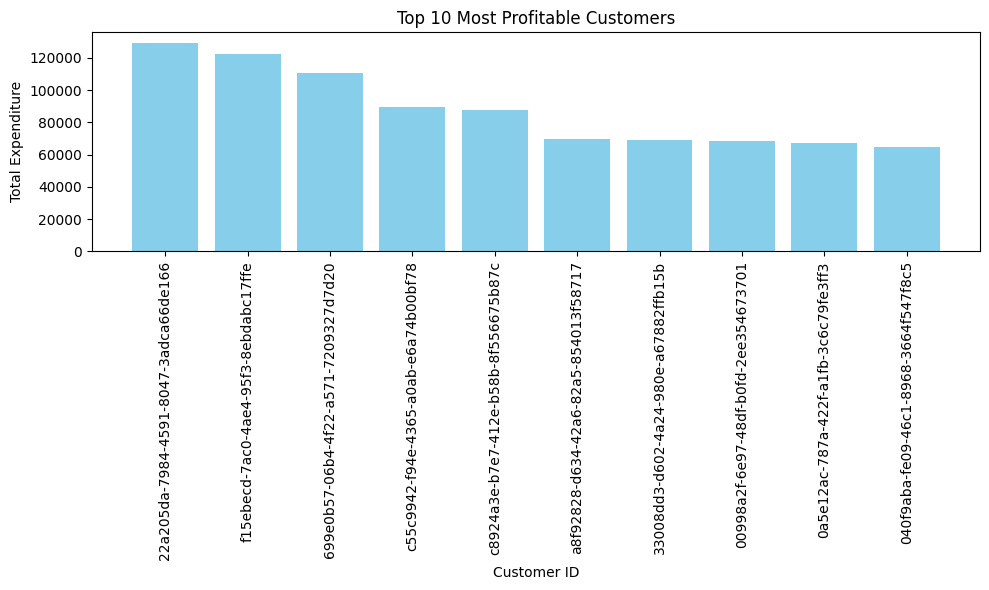

In [133]:
plt.figure(figsize=(10, 6))
plt.bar(top_10['customer_id'], top_10['total_expenditure'], color='skyblue')
plt.xlabel('Customer ID')
plt.ylabel('Total Expenditure')
plt.title('Top 10 Most Profitable Customers')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

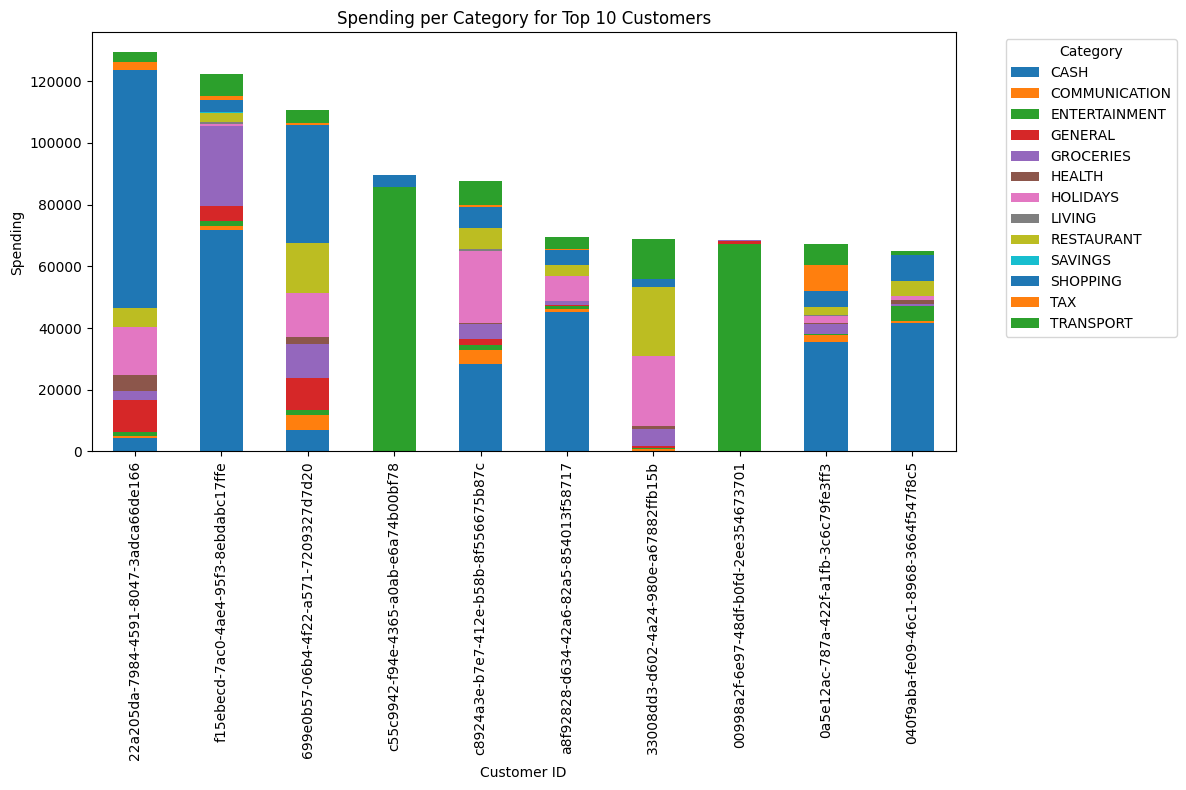

In [134]:
top_customers = most_profitable_customers.head(10)

# Filter sum_of_categories_per_customer for the top 3 customers
top_spending_per_category = sum_of_categories_per_customer[sum_of_categories_per_customer['customer_id'].isin(top_customers['customer_id'])]

# Pivot the DataFrame to have customer_id as rows and category as columns
pivot_df = top_spending_per_category.pivot(index='customer_id', columns='category', values='amount_chf').fillna(0)
# Sort pivot_df based on total expenditure in descending order
pivot_df = pivot_df.loc[top_customers['customer_id']]

# Plot the spending per category for the top 10 customers
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.xlabel('Customer ID')
plt.ylabel('Spending')
plt.title('Spending per Category for Top 10 Customers')
plt.xticks(rotation=90)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [130]:
sum_of_categories_per_customer.sort_values('amount_chf', ascending=False)

level_0  index                           customer_id       category  \
17019    17019  17019  c55c9942-f94e-4365-a0ab-e6a74b00bf78  ENTERTAINMENT   
3008      3008   3008  22a205da-7984-4591-8047-3adca66de166       SHOPPING   
21028    21028  21028  f15ebecd-7ac0-4ae4-95f3-8ebdabc17ffe           CASH   
23          23     23  00998a2f-6e97-48df-b0fd-2ee354673701  ENTERTAINMENT   
13269    13269  13269  9a35cdf7-0fd0-41f1-af05-0fe71d8a36db  ENTERTAINMENT   
...        ...    ...                                   ...            ...   
9316      9316   9316  6d6ce3ef-b20b-430d-a3cf-dcb3f43a352c        GENERAL   
6902      6902   6902  50c102f6-643b-48fa-be92-93e9a2a68376  COMMUNICATION   
183        183    183  028bcaef-639b-4595-8005-6b2622c10420  COMMUNICATION   
19773    19773  19773  e32528d7-ef72-4a65-bc70-e11c9d05d840      TRANSPORT   
18131    18131  18131  d0907ce5-36d4-45be-9333-dfbd8fde5ab7           CASH   

       amount_chf  total_expenditure  
17019    85580.43           89467.71  
3008     76873.25          129348.78  
21028    71617.02          122317.63  
23       67146.22           68428.86  
13269    52762.99           63677.92  
...           ...                ...  
9316         0.03           10400.35  
6902         0.02             129.81  
183          0.02               0.02  
19773        0.01              35.64  
18131        0.01              18.55  

[22488 rows x 6 columns]